In [1]:
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"
import sys
from utils.tools import load_obj, save_obj
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

In [2]:
def iewt1d(ewt, mfb):
    # 转化为原始信号
    real = all(np.isreal(ewt[0]))
    if real:
        rec = np.zeros(len(ewt[0]))
        for i in range(0,len(ewt)):
            rec += np.real(np.fft.ifft(np.fft.fft(ewt[i])*mfb[i]))
    else:
        rec = np.zeros(len(ewt[0]))*0j
        for i in range(0,len(ewt)):
            rec += np.fft.ifft(np.fft.fft(ewt[i])*mfb[i])
    return rec

In [3]:
def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))
def metircs(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    mape = MAPE(pred, true)
    return {"rmse":rmse, "r2":r2, "mape":mape}

## 数据加载

In [4]:
TARGET = "rv"
cols = [TARGET]
df = pd.read_csv(f"./data/{TARGET}.csv", index_col=[0], parse_dates=True)
df.head()
metrics_dict = {}

,stock_id,rv,rv0,rv1,rv2,rv0_mfb,rv1_mfb,rv2_mfb
Date,,,,,,,,
2012-02-20,0,-8.010988,-7.996523,-0.386654,0.397335,1.000000,0.000000,0.0
2012-02-21,0,-8.849957,-7.997371,-0.395975,-0.395132,1.000000,0.000000,0.0
2012-02-22,0,-8.861943,-7.998217,-0.405250,-0.445672,0.998193,0.060083,0.0
2012-02-23,0,-9.099481,-7.999062,-0.414478,-0.618561,0.707107,0.707107,0.0
2012-02-24,0,-8.986639,-7.999905,-0.423655,-0.562358,0.060083,0.998193,0.0


In [5]:
N = 3

## 直接重构

In [6]:
tmp_mfb = df[[f"rv{i}_mfb" for i in range(N)]].values
ewt_pred = df[[f"rv{i}" for i in range(N)]].values

df_for_inverse = pd.DataFrame(np.concatenate([ewt_pred, tmp_mfb], axis=1), index=df["stock_id"])
reconstruction = df_for_inverse.groupby(df_for_inverse.index).apply(lambda x:iewt1d(x.iloc[:, :N].values.T, x.iloc[:, -N:].values.T))
reconstruction = np.concatenate(reconstruction.values)

In [7]:
metircs(df["rv"].values, reconstruction)

{'rmse': 0.05571936805402251,
 'r2': 0.9968427499744932,
 'mape': 0.005752867992652166}

## lstm-ewt 预测

In [8]:
seq_len, pred_len = 40, 1
HORIZON = 10
total_len = len(df)

In [9]:
for model_name in ["lstm"]:
    # 不同horizon下的分量预测结果
    lstmewt_horizon_dict = {}
    for hn in range(1, HORIZON+1):
        # 加载不同horizon下的各分量预测结果
        pred_lst = []
        true_lst = []
        for i in range(N):
            true, pred = load_obj(f"./results/mydata/{model_name}_mydata_ftS_sl{seq_len}_ll0_pl{pred_len}_is1_os1_hn{hn}_bs32_lr0.001_{TARGET}{i}_standar/true_pred.pkl")
            true_lst.append(true)
            pred_lst.append(pred)
        pred_lstm = np.concatenate(pred_lst,axis=-1)
        true_lstm = np.concatenate(true_lst, axis=-1)
        lstmewt_horizon_dict[hn] = [true_lstm, pred_lstm]

    lstmewt_metrics = {}
    trues_test_lst, preds_test_lst = [], []
    for horizon in range(1, HORIZON+1):
        out_len = max(pred_len, horizon)
        train_idxs, val_idxs, test_idxs = load_obj(f"./save_file/idxs{out_len}.pkl")
        gap = horizon - 1
        add_len = seq_len+gap
        train_idxs += add_len
        val_idxs += add_len
        test_idxs += add_len
        idxs = [i for i in train_idxs.tolist()+val_idxs.tolist()+test_idxs.tolist()]

        df_copy = df.copy()
        condition = pd.Series(range(len(df_copy))).isin(idxs).values
        df_copy.loc[condition, [f"rv{i}_pred" for i in range(N)]] = lstmewt_horizon_dict[horizon][1].squeeze()
        df_copy.loc[~condition, [f"rv{i}_pred" for i in range(N)]] = df_copy.loc[~condition, [f"rv{i}" for i in range(N)]].values

        tmp_mfb = df_copy[[f"rv{i}_mfb" for i in range(N)]].values
        ewt_pred = df_copy[[f"rv{i}_pred" for i in range(N)]].values

        df_for_inverse = pd.DataFrame(np.concatenate([ewt_pred, tmp_mfb], axis=1), index=df_copy["stock_id"])
        reconstruction = df_for_inverse.groupby(df_for_inverse.index).apply(lambda x:iewt1d(x.iloc[:, :N].values.T, x.iloc[:, -N:].values.T))
        reconstruction = np.concatenate(reconstruction.values)
        # 分量的预测效果
        # metircs(df_copy.iloc[test_idxs]["rv2"].values, ewt_pred[:, -1][test_idxs])
        true_test = df_copy.iloc[test_idxs]["rv"].values
        pred_test = reconstruction[test_idxs]

        lstmewt_metrics[f"horizon{horizon}"] = metircs(true_test, pred_test)
        trues_test_lst.append(true_test)
        preds_test_lst.append(pred_test)
    trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
    lstmewt_metrics["avghorizon"] = metircs(trues_test_all, preds_test_all)
    metrics_dict[f"{model_name}ewt"] = pd.DataFrame(lstmewt_metrics).T

In [10]:
i = 300
metircs(true_lstm[-i:, 0, 0], pred_lstm[-i:, 0, 0])
metircs(true_lstm[-i:, 0, 1], pred_lstm[-i:, 0, 1])
metircs(true_lstm[-i:, 0, 2], pred_lstm[-i:, 0, 2])

{'rmse': 0.011593470572060454,
 'r2': 0.9924158437534248,
 'mape': 0.0013345073060143785}

{'rmse': 0.005251188024231342,
 'r2': 0.9993275522599573,
 'mape': 0.12677916525467114}

{'rmse': 0.4372269741704058,
 'r2': -0.008451325415049338,
 'mape': 1.3457472729952107}

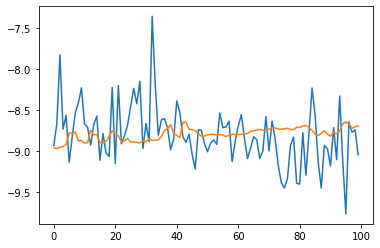

In [12]:
plt.plot(df_copy["rv"][-100:].values)
plt.plot(reconstruction[-100:])

In [13]:
target_horizon = 1
target = df_copy["rv"].values
lstmewt_target_horizon_data = [target, reconstruction, ewt_pred]

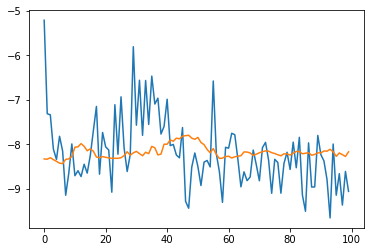

In [14]:
plt.plot(true_test[:100])
plt.plot(pred_test[:100])

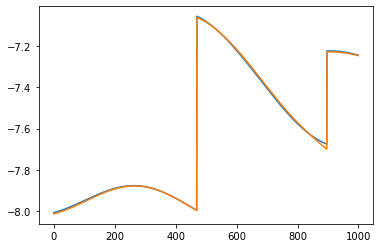

In [15]:
plt.plot(df_copy["rv0"].iloc[test_idxs].values[:1000])
plt.plot(df_copy["rv0_pred"].iloc[test_idxs].values[:1000])

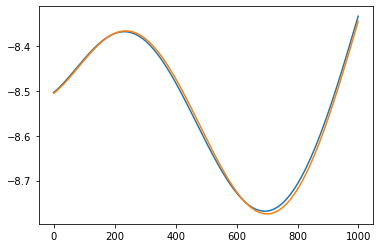

In [16]:
plt.plot(df_copy["rv0"].values[-1000:])
plt.plot(df_copy["rv0_pred"].values[-1000:])

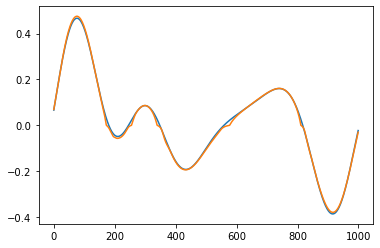

In [17]:
plt.plot(df_copy["rv1"].values[-1000:])
plt.plot(df_copy["rv1_pred"].values[-1000:])

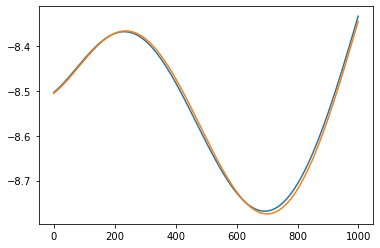

In [18]:
plt.plot(true_lstm[-1000:, 0, 0])
plt.plot(pred_lstm[-1000:, 0, 0])

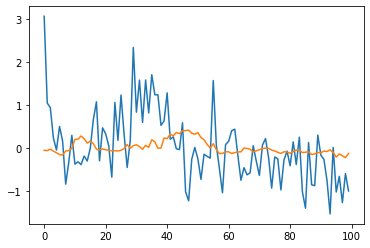

In [19]:
plt.plot(df_copy["rv2"].iloc[test_idxs].values[:100])
plt.plot(df_copy["rv2_pred"].iloc[test_idxs].values[:100])

In [20]:
# lstmewt_metrics = {}
# out_len = max(pred_len, horizon)
# gap = horizon - 1
# pre_len = seq_len + gap
# pre_df = df.groupby("stock_id").apply(lambda x:x[:pre_len])
# post_df = df.groupby("stock_id").apply(lambda x:x[pre_len:])
# target = pd.concat([pre_df, post_df], axis=0).sort_index()["rv"]

# # 替换预测部分
# post_df.loc[:, [f"rv{i}" for i in range(N)]] = lstmewt_horizon_dict[horizon][1][:,0,:]
# tmp_df = pd.concat([pre_df, post_df], axis=0).sort_index()
# for col in cols:
#     tmp_mfb = tmp_df[[f"{col}{i}_mfb" for i in range(N)]].values
#     ewt_pred = tmp_df[[f"{col}{i}" for i in range(N)]].values
#     # 重构
#     reconstruction = iewt1d(ewt_pred.T, tmp_mfb.T)

#     # 预测评估
#     trues_test = target.values[test_idxs]
#     preds_test = reconstruction[test_idxs]
#     trues_test_lst.append(trues_test)
#     preds_test_lst.append(preds_test)

#     lstmewt_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
# if horizon == target_horizon:
#     lstmewt_target_horizon_data = [target, reconstruction, ewt_pred]

# metrics_dict["lstmewt"] = pd.DataFrame(lstmewt_metrics).T

## lstm 预测

In [11]:
seq_len, pred_len = 40, 1
HORIZON = 10

In [12]:
for model_name in ["lstm", "lstmdecompose"]:
    lstm_horizon_dict = {}
    for hn in range(1, HORIZON+1):
        true, pred = load_obj(f"./results/mydata/{model_name}_mydata_ftS_sl{seq_len}_ll0_pl{pred_len}_is1_os1_hn{hn}_bs32_lr0.001_{TARGET}_standar/true_pred.pkl")
        lstm_horizon_dict[hn] = [true, pred]
        
    lstm_metrics = {}
    trues_test_lst, preds_test_lst = [], []
    for horizon in range(1, HORIZON+1):
        out_len = max(pred_len, horizon)
        train_idxs, val_idxs, test_idxs = load_obj(f"./save_file/idxs{out_len}.pkl")
        gap = horizon - 1
        add_len = seq_len+gap
        train_idxs += add_len
        val_idxs += add_len
        test_idxs += add_len
        idxs = [i for i in train_idxs.tolist()+val_idxs.tolist()+test_idxs.tolist()]

        df_copy = df.copy()
        condition = pd.Series(range(len(df_copy))).isin(idxs).values
        df_copy.loc[condition, [f"rv_pred"]] = lstm_horizon_dict[horizon][1].squeeze()
        df_copy.loc[~condition, [f"rv_pred"]] = df_copy.loc[~condition, [f"rv"]].values

        # 分量的预测效果
        # metircs(df_copy.iloc[test_idxs]["rv2"].values, ewt_pred[:, -1][test_idxs])
        true_test = df_copy.iloc[test_idxs]["rv"].values
        pred_test = df_copy.iloc[test_idxs]["rv_pred"].values

        lstm_metrics[f"horizon{horizon}"] = metircs(true_test, pred_test)
        trues_test_lst.append(true_test)
        preds_test_lst.append(pred_test)
    trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
    lstm_metrics["avghorizon"] = metircs(trues_test_all, preds_test_all)
    metrics_dict[f"{model_name}"] = pd.DataFrame(lstm_metrics).T

In [13]:
metircs(true.squeeze()[:], pred.squeeze()[:])

{'rmse': 0.7517967946894438,
 'r2': 0.42972652609026496,
 'mape': 0.07950508957698399}

In [14]:
metrics_dict["lstmewt"]
metrics_dict["lstm"]
metrics_dict["lstmdecompose"]

,rmse,r2,mape
horizon1,0.599330,0.612675,0.061931
horizon2,0.646348,0.549507,0.067055
horizon3,0.659449,0.530677,0.068625
horizon4,0.676465,0.506014,0.070554
horizon5,0.683098,0.495875,0.071344
horizon6,0.692860,0.481410,0.072462
horizon7,0.698443,0.472973,0.073042
horizon8,0.703974,0.464254,0.073851
horizon9,0.705814,0.461132,0.074087
horizon10,0.710060,0.454243,0.074587


,rmse,r2,mape
horizon1,0.615033,0.592112,0.063480
horizon2,0.653825,0.539023,0.067725
horizon3,0.679823,0.501229,0.070843
horizon4,0.693449,0.480899,0.072166
horizon5,0.712622,0.451357,0.074671
horizon6,0.723349,0.434766,0.075739
horizon7,0.731318,0.422192,0.076656
horizon8,0.739886,0.408199,0.077638
horizon9,0.745679,0.398541,0.078608
horizon10,0.754849,0.383221,0.079325


,rmse,r2,mape
horizon1,0.613522,0.594114,0.063347
horizon2,0.652271,0.541212,0.067487
horizon3,0.676624,0.505912,0.070441
horizon4,0.691524,0.483776,0.072129
horizon5,0.708590,0.457547,0.074106
horizon6,0.722178,0.436595,0.075661
horizon7,0.729763,0.424647,0.076477
horizon8,0.740219,0.407666,0.077953
horizon9,0.747638,0.395377,0.078601
horizon10,0.755667,0.381883,0.079465


## 模型评估

In [15]:
def evaluation_show(taget_indictor, target_horizon, sort=True):
    hist_dict = {}
    for key, value in metrics_dict.items():
        hist_dict[key] = value[taget_indictor][target_horizon]
    if sort:
        hist_dict = dict(sorted(hist_dict.items(), key=lambda x:x[1]))
    fig = plt.figure(figsize=(10, 6))
    x, width = 0, 0.25
    xtick_lst = []
    xlabel_lst = []
    for key, value in hist_dict.items():
        xtick_lst.append(x)
        xlabel_lst.append(key)
        plt.bar(x, value, width=width, label=key)
        x += width
    plt.xticks(xtick_lst, xlabel_lst)
    plt.title(f"{taget_indictor}_{target_horizon}")
    plt.legend();
    return fig, hist_dict

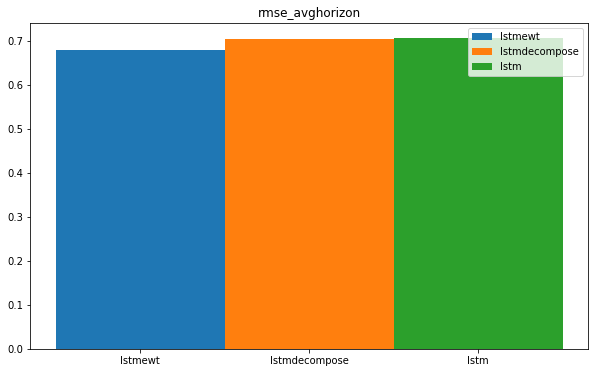

In [16]:
target_horizon = "avghorizon"
taget_indictor = 'rmse'
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)

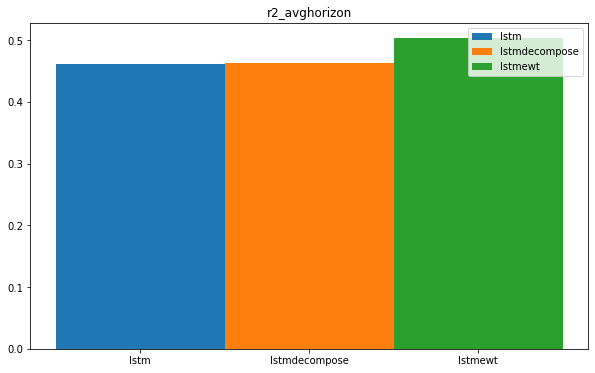

In [17]:
taget_indictor = 'r2'
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)

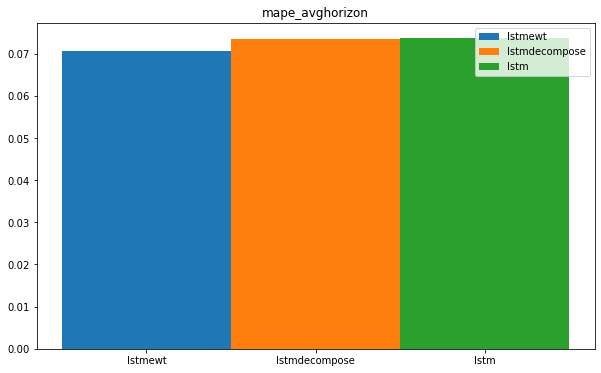

In [18]:
taget_indictor = 'mape'
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)

### save_metrics

In [19]:
save_metrics = {}
for key, value in metrics_dict.items():
    save_metrics[key] = metrics_dict[key].loc[target_horizon, :].to_dict()

In [21]:
pd.DataFrame(save_metrics)

,lstmewt,lstm,lstmdecompose
rmse,0.678335,0.706203,0.705073
r2,0.502981,0.461303,0.463026
mape,0.070750,0.073679,0.073561


In [47]:
a = metrics_dict["lstmewt"].copy()
a.columns = a.columns+"lstmewt"
b = metrics_dict["lstm"].copy()
b.columns= b.columns+"lstm"

In [48]:
pd.concat([a, b], axis=1).sort_index(axis=1)

,mapelstm,mapelstmewt,r2lstm,r2lstmewt,rmselstm,rmselstmewt
horizon1,0.063480,0.061931,0.592112,0.612675,0.615033,0.599330
horizon2,0.067725,0.067055,0.539023,0.549507,0.653825,0.646348
horizon3,0.070843,0.068625,0.501229,0.530677,0.679823,0.659449
horizon4,0.072166,0.070554,0.480899,0.506014,0.693449,0.676465
horizon5,0.074671,0.071344,0.451357,0.495875,0.712622,0.683098
horizon6,0.075739,0.072462,0.434766,0.481410,0.723349,0.692860
horizon7,0.076656,0.073042,0.422192,0.472973,0.731318,0.698443
horizon8,0.077638,0.073851,0.408199,0.464254,0.739886,0.703974
horizon9,0.078608,0.074087,0.398541,0.461132,0.745679,0.705814
horizon10,0.079325,0.074587,0.383221,0.454243,0.754849,0.710060


### save_metrics

In [32]:
save_metrics = {}
for key, value in metrics_dict.items():
    save_metrics[key] = metrics_dict[key].loc[target_horizon, :].to_dict()

In [33]:
save_metrics_df = pd.DataFrame(save_metrics).T

In [34]:
save_metrics_df.columns = [["RV"]*3, ["rmse", "r2", "mape"]]

In [35]:
save_metrics_df

RV                    
             rmse        r2      mape
lstmewt  0.678335  0.502981  0.070750
lstm     0.706203  0.461303  0.073679

## horizon

In [22]:
save_metrics = {}
target_horizon_lst = ["horizon1", "horizon3", "horizon6", "horizon10", "avghorizon"]
for key, value in metrics_dict.items():
    save_metrics[key] = metrics_dict[key].loc[target_horizon_lst, :]["rmse"].to_dict()

In [23]:
save_metrics_df = pd.DataFrame(save_metrics)

In [24]:
save_metrics_df

,lstmewt,lstm,lstmdecompose
horizon1,0.599330,0.615033,0.613522
horizon3,0.659449,0.679823,0.676624
horizon6,0.692860,0.723349,0.722178
horizon10,0.710060,0.754849,0.755667
avghorizon,0.678335,0.706203,0.705073


In [25]:
save_metrics_df.to_csv(f"./save_file/{TARGET}_horizons.csv")